<a href="https://www.kaggle.com/code/jlcordoba/simple-submission?scriptVersionId=94949219" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
#reading CSV with pandas
Taxonomy = pd.read_csv('../input/birdclef-2022/eBird_Taxonomy_v2021.csv')
test = pd.read_csv('../input/birdclef-2022/test.csv')
train_metadata = pd.read_csv('../input/birdclef-2022/train_metadata.csv')
submission = pd.read_csv('../input/birdclef-2022/sample_submission.csv')
from os import path
from pydub import AudioSegment
import seaborn as sns
from scipy.io.wavfile import read
from statsmodels.graphics.tsaplots import plot_acf
from scipy import signal
from scipy.io import wavfile


#transform into dataframe
df_taxonomy = pd.DataFrame(Taxonomy)

df_test = pd.DataFrame(test)

df_train = pd.DataFrame(train_metadata)

df_submission = pd.DataFrame(submission)









In [2]:
#opening the scored bird file
with open('../input/birdclef-2022/scored_birds.json','r') as f:
    data = json.load(f)
    

In [3]:
#index of the scored rows
index_row_scored = []
for i in data:
    a=i.strip('"')
    for j in range(len(df_train["primary_label"])):
        if df_train["primary_label"][j] == a:
            index_row_scored.append(j)


In [4]:

from os import listdir
from os.path import isfile, join
rated_list = []
for i in data:
    onlyfiles = [f for f in listdir("../input/birdclef-2022/train_audio/"+i) if isfile(join("../input/birdclef-2022/train_audio/"+i,f))]
    rated_list.append(i)
    rated_list.append(onlyfiles)
    

In [5]:
#Function to extract features from the audios
def features_extractor(file):
    #load the file (audio)
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    #we extract mfcc
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    #in order to find out scaled feature we do mean of transpose of value
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features


In [6]:
#We will use a dataframe with the scored birds just to see that everything works fine 
#without spending so much time
df_scored = df_train.copy()
for i in df_train.index:
    #if df_train['rating'][i]<2.5:
        #df_train.drop([i],axis = 0, inplace = True)
    if i not in index_row_scored:
        df_scored.drop([i],axis = 0, inplace = True)

In [7]:

from tqdm import tqdm
# Now we iterate through every audio file and extract features 
# using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(df_scored.iterrows()):
    file_name = os.path.join(os.path.abspath("../input/birdclef-2022/train_audio/"),str(row["filename"]))
    final_class_labels=row["primary_label"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

1266it [13:38,  1.55it/s]


In [8]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','primary_label'])
extracted_features_df.head()

,feature,primary_label
0,"[-472.28574, 60.7976, -25.217098, 57.126324, 1...",akiapo
1,"[-446.27298, 55.930138, -19.547518, 57.774445,...",akiapo
2,"[-266.47318, 75.57892, -7.943713, 50.27808, -4...",akiapo
3,"[-404.56955, 26.65804, -27.88428, 29.090647, -...",akiapo
4,"[-381.15158, 27.375917, -63.842342, 60.094864,...",akiapo


In [9]:
#Now we split the data into train and test
from imblearn.over_sampling import RandomOverSampler #we improved accuracy with this!
oversample = RandomOverSampler(sampling_strategy='minority')
# Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['primary_label'].tolist())
# Label Encoding -> Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))
### Train Test Split
from sklearn.model_selection import train_test_split
#X,y = oversample.fit_resample(X, y)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.02)

In [10]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
trainedforest = RandomForestClassifier(n_estimators = 700).fit(X_train, y_train)
predictionforest = trainedforest.predict(X_test)
print(classification_report(y_test,predictionforest))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          12       1.00      0.56      0.71         9
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
#we create feature names
X=np.array(extracted_features_df['feature'].tolist())
X_t = []
X__t = []
for j in range(0,40):
    X_t = []
    for i in range(len(X)):
        X_t.append(X[i][j])
    X__t.append(X_t)
    
feature_names = [f"feature {i}" for i in range(X.shape[1])]


<AxesSubplot:>

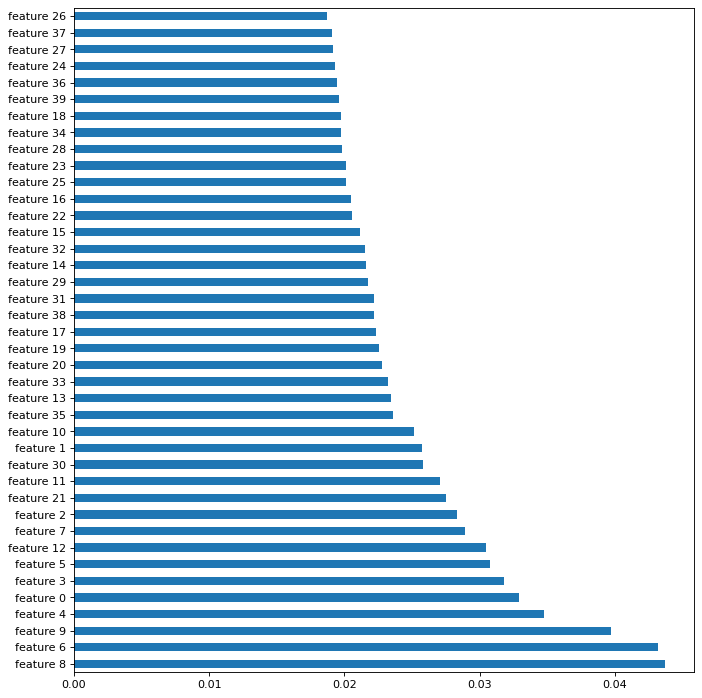

In [12]:
#Feature importance
from matplotlib.pyplot import figure
figure(num = None, figsize=(10,11), dpi = 80, facecolor = 'w', edgecolor = 'k')
feat_importances = pd.Series(trainedforest.feature_importances_, index = feature_names)
feat_importances.nlargest(40).plot(kind = 'barh')

<AxesSubplot:>

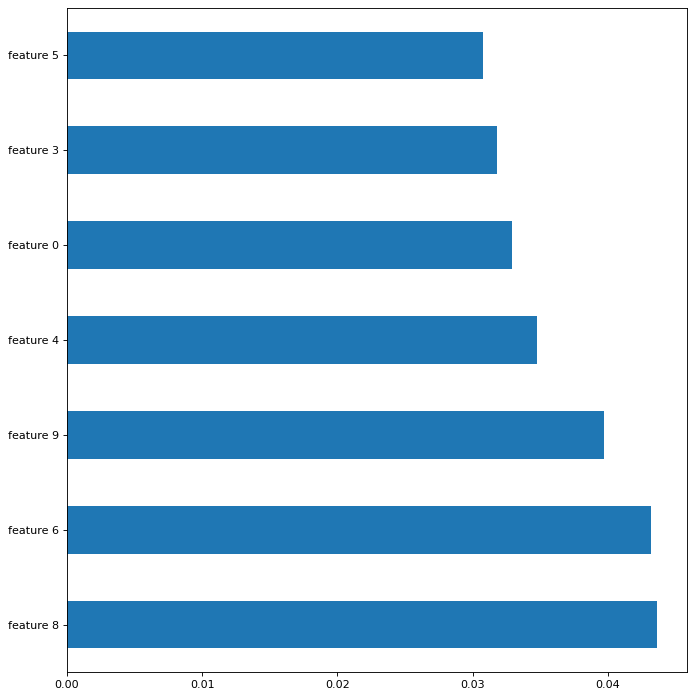

In [13]:
#We use 7 features

from matplotlib.pyplot import figure
figure(num = None, figsize=(10,11), dpi = 80, facecolor = 'w', edgecolor = 'k')
feat_importances = pd.Series(trainedforest.feature_importances_, index = feature_names)
feat_importances.nlargest(7).plot(kind = 'barh')

In [14]:
#We select the 7 features with more importance in our data
X_prueba = X
X_prueb = X_prueba.tolist()
X_pru = []
X_pri = []

for i in range(len(X)):
    for j in range(0,40):
        if j==6 or j==8 or j==9 or j==4 or j==0 or j==5 or j==12:
            X_pru.append(X_prueb[i][j])
    X_pri.append(X_pru)
    X_pru = []
            
                
X_pro = np.array([np.array(xi) for xi in X_pri])
print(X_pro)
len(X_pro)

[[-472.28573608   11.26227093   18.62749672 ...   -5.06986189
    17.48283386   -1.81247914]
 [-446.27297974   -4.24799156    7.91808462 ...   -8.31196499
    16.52576447   -3.09710312]
 [-266.47317505   -4.90197325   10.85512543 ...  -10.55334282
    13.49816227   -9.29772758]
 ...
 [-560.30517578  -56.60279083   -2.87694883 ...   -6.43454218
     5.96341133   -4.90424633]
 [-481.96133423  -31.65890312  -23.69248009 ...  -19.49150467
    -8.04002953   -9.09109688]
 [-461.07327271  -65.89056396   -0.76734853 ...  -15.94899559
    -5.16784239   -8.86606216]]


1266

In [15]:
#wedivide again between train and test
X_train,X_test,y_train,y_test=train_test_split(X_pro,y,test_size=0.2)
X_train.shape
X_test.shape

(254, 7)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
# No of classes
num_labels=y.shape[1]

In [17]:
#Creation of the model
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(7,)))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

2022-05-06 22:11:59.339046: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [19]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
num_epochs = 200
num_batch_size = 32
checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()
model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

2022-05-06 22:12:01.536084: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
32/32 [==============================] - 1s 11ms/step - loss: 2.3383 - accuracy: 0.3014 - val_loss: 2.1588 - val_accuracy: 0.3780

Epoch 00001: val_loss improved from inf to 2.15884, saving model to ./audio_classification.hdf5
Epoch 2/200
32/32 [==============================] - 0s 4ms/step - loss: 2.0779 - accuracy: 0.3696 - val_loss: 2.0947 - val_accuracy: 0.3780

Epoch 00002: val_loss improved from 2.15884 to 2.09465, saving model to ./audio_classification.hdf5
Epoch 3/200
32/32 [==============================] - 0s 4ms/step - loss: 2.0346 - accuracy: 0.3725 - val_loss: 2.0804 - val_accuracy: 0.3780

Epoch 00003: val_loss improved from 2.09465 to 2.08035, saving model to ./audio_classification.hdf5
Epoch 4/200
32/32 [==============================] - 0s 4ms/step - loss: 2.0269 - accuracy: 0.3785 - val_loss: 2.0765 - val_accuracy: 0.3780

Epoch 00004: val_loss improved from 2.08035 to 2.07647, saving model to ./audio_classification.hdf5
Epoch 5/200
32/32 [================

In [20]:

# Let's check the accuracy!
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.5354330539703369


In [21]:
predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x, axis = 1)
predict_x[1]

array([6.4500961e-03, 2.8510297e-02, 3.2098841e-02, 1.8984754e-02,
       1.6349414e-03, 6.0416651e-03, 2.7788146e-03, 1.0788350e-02,
       2.5405170e-02, 4.7372552e-03, 5.0292551e-03, 1.3210098e-03,
       8.7446049e-02, 2.8035127e-02, 1.0700813e-01, 3.8296491e-04,
       2.6756451e-02, 2.0959915e-03, 4.5931849e-01, 7.8412838e-02,
       6.6763528e-02], dtype=float32)

In [22]:
#Here we split the test audio file
test_audio_dir = '../input/birdclef-2022/test_soundscapes/'
file_list = [f.split('.')[0] for f in sorted(os.listdir(test_audio_dir))]

In [23]:
with open('../input/birdclef-2022/scored_birds.json') as sbfile:
    scored_birds = json.load(sbfile)

In [24]:
pred = {'row_id': [], 'target': []}

In [25]:
# Process audio files and make predictions
for afile in file_list:
    
    # Complete file path
    path = test_audio_dir + afile + '.ogg'
    
    # Open file with librosa and split signal into 5-second chunks
    # sig, rate = librosa.load(path)
    # ...
    
    # Let's assume we have a list of 12 audio chunks (1min / 5s == 12 segments)
    chunks = [[] for i in range(12)]

In [26]:
chunks

[[], [], [], [], [], [], [], [], [], [], [], []]

In [27]:
y_test.shape
predict_x.shape
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#score = f1_score(str(y_test[1]),str(predict_x[1]).replace(".", ""), average = None)
#fil_acc_orig = accuracy_score(X_test,predict_x)

X_test

y



array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's prepare the test file to create the submision csv

In [28]:
# we will divide the test audio in 12 audios of 5 seconds.

from pydub import AudioSegment
from pydub.utils import make_chunks 
sound = AudioSegment.from_file("../input/birdclef-2022/test_soundscapes/soundscape_453028782.ogg")

chunk_length_ms = 5000 # pydub calculates in millisec 
chunks = make_chunks(sound,chunk_length_ms) #Make chunks of one sec 
for i, chunk in enumerate(chunks): 
    chunk_name = "{0}.ogg".format(i) 
    print ("exporting", chunk_name) 
    chunk.export(chunk_name, format="ogg") 


exporting 0.ogg
exporting 1.ogg
exporting 2.ogg
exporting 3.ogg
exporting 4.ogg
exporting 5.ogg
exporting 6.ogg
exporting 7.ogg
exporting 8.ogg
exporting 9.ogg
exporting 10.ogg
exporting 11.ogg


In [29]:
# Lets exstract the features from the test audio
import librosa
import numpy as np

def features_extractor(file):
    #load the file (audio)
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    #we extract mfcc
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    #in order to find out scaled feature we do mean of transpose of value
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features


import os
extracted_features_=[]
for i in range(0,12):
    file_name = os.path.join(os.path.abspath("./"),str(i) + ".ogg")
    data=features_extractor(file_name)
    extracted_features_.append([data])

In [30]:
import pandas as pd
extracted_features_df_=pd.DataFrame(extracted_features_,columns=['feature'])

In [31]:
X_=np.array(extracted_features_df_['feature'].tolist())

In [32]:
#We use the same features than before
X_prueba = X_
X_prueb = X_prueba.tolist()
X_pru = []
X_pri = []

for i in range(len(X_)):
    for j in range(0,40):
        if j==6 or j==8 or j==9 or j==4 or j==0 or j==5 or j==12:
            X_pru.append(X_prueb[i][j])
    X_pri.append(X_pru)
    X_pru = []
            
                
X_pro = np.array([np.array(xi) for xi in X_pri])

In [33]:
with open('../input/birdclef-2022/scored_birds.json') as sbfile:
    scored_birds = json.load(sbfile)

In [34]:
predict__=model.predict(X_pro)

In [35]:
# This is where we will store our results
pred = {'row_id': [], 'target': []}

# Process audio files and make predictions
for afile in file_list:
    
    # Complete file path
    path = test_audio_dir + afile + '.ogg'
    
    # Open file with librosa and split signal into 5-second chunks
    # sig, rate = librosa.load(path)
    # ...
    
    # Let's assume we have a list of 12 audio chunks (1min / 5s == 12 segments)
    chunks = [[] for i in range(12)]
    
    # Make prediction for each chunk
    # Each scored bird gets a random value in our case
    # since we don't actually have a model
    for i in range(len(chunks)):        
        chunk_end_time = (i + 1) * 5
        j=0
        for bird in scored_birds:
            
            # This is our random prediction score for this bird
            score = predict__[i][j]
            j=j+1
            # Assemble the row_id which we need to do for each scored bird
            row_id = afile + '_' + bird + '_' + str(chunk_end_time)
            
            # Put the result into our prediction dict and
            # apply a "confidence" threshold of 0.5
            pred['row_id'].append(row_id)
            pred['target'].append(True if score > 0.5 else False)

In [36]:
results = pd.DataFrame(pred, columns = ['row_id', 'target'])

# Quick sanity check
print(results.head()) 
    
# Convert our results to csv
results.to_csv("submission.csv", index=False)

                          row_id  target
0  soundscape_453028782_akiapo_5   False
1  soundscape_453028782_aniani_5   False
2  soundscape_453028782_apapan_5   False
3  soundscape_453028782_barpet_5   False
4  soundscape_453028782_crehon_5   False
